In [1]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
import os
from scipy.sparse import lil_matrix
from scipy.sparse import linalg
from scipy.sparse import csr_matrix
import pdb
import time

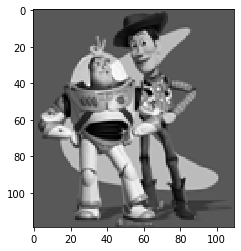

In [2]:
img = cv2.imread('samples/toy_problem.png')
toy_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
toy_img = cv2.cvtColor(toy_img, cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")

## Part 1 Toy Problem (20 pts)

In [3]:
def toy_reconstruct(toy_img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    start = time.time()
    im_h, im_w = toy_img.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w) # value is transposed??

#     print("im_h, im_w ", im_h, im_w)
#     print("im2var shape ", im2var.shape)
#     print("toy_img shape ", toy_img.shape)
    # Objective 1
    #  e = e + 1
    # A[e][im2var[y][x+1] = 1
    # A[e][im2var[y][x]] = -1
    # b[e] = im[y][x+1] - im[y][x]
    
    # A matrix bounds im_h * im_w
    # https://piazza.com/class/k5cumohrew35en?cid=362 ??
    n_constraints = 2 * im_h * im_w + 1 #number of constraints
    n_pixels = im_h * im_w
    A = lil_matrix((n_constraints, n_pixels), dtype = np.float64)
#     print("A ", A.shape)
    b = np.zeros(n_constraints, np.float64)
#     print("b ", b.shape)
    
    e = 0
    A[e, im2var[0][0]] = 1
    b[e] = toy_img[0][0]
#     pdb.set_trace()
    for y in range(im_h): #im2var.shape[0])
        for x in range(im_w): #im2var.shape[1])

            # Need to handle border cases. x == im_w-1 and y == im_h-1
            #Objective 1
            e = e + 1
            if(x != im_w-1):
                A[e, im2var[y][x+1]] = 1
                A[e, im2var[y][x]] = -1
                b[e] = toy_img[y][x+1] - toy_img[y][x]
            else:
                A[e, im2var[y][x]] = -1
                b[e] = -toy_img[y][x]

            #Objective 2
            e = e + 1
            if(y != im_h-1):
                A[e, im2var[y+1][x]] = 1
                A[e, im2var[y][x]] = -1
                b[e] = toy_img[y+1][x] - toy_img[y][x]
            else:
                A[e, im2var[y][x]] = -1
                b[e] = -toy_img[y][x]
    
    v = linalg.lsqr(csr_matrix(A), b)
    res = v[0].reshape(im_h, im_w)
    print("Total time taken ", time.time() - start)
    return res

In [4]:
im_out = toy_reconstruct(toy_img)
# print("toy_img ", toy_img)
# print("im_out ", im_out)
if im_out.any():
    print("Error is: ", np.sqrt(((im_out - toy_img)**2).sum()))

Total time taken  1.4022760391235352
Error is:  0.0001901762385198699


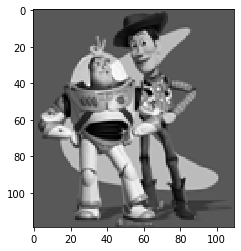

In [5]:
plt.imshow(im_out, cmap='gray')

## Preparation

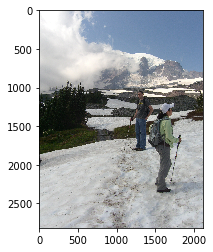

In [6]:
# Feel free to change image
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


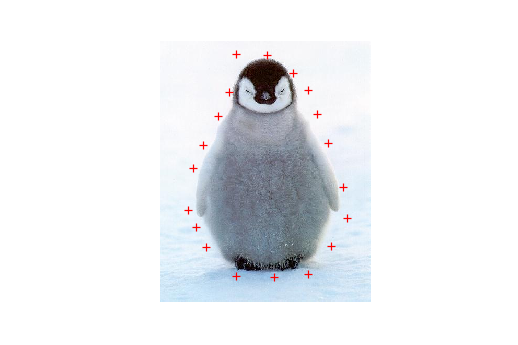

In [8]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

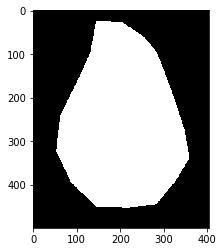

In [9]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


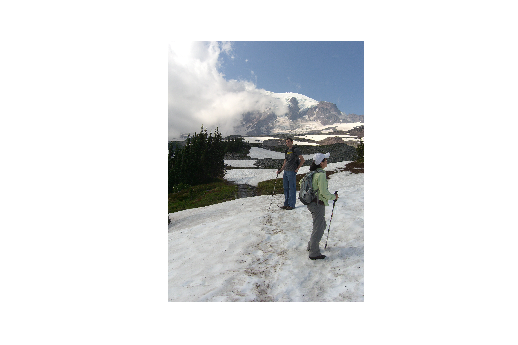

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

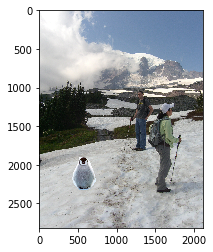

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)

## Part 2 Poisson Blending (50 pts)

In [12]:
def computeIm2var(mask):
    (H, W) = size(mask)
    Im2var = zeros(H, W)
    v = 0
    for y in range(H):
        for x in range(W):
            if(mask[y][x]):
                v = v + 1
                Im2var[y][x] = v
    return Im2var
    
def poisson_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
#     print("cropped_object: ", cropped_object.shape)
#     print("object_mask: ", object_mask.shape)
#     print("background_mask: ", background_img.shape)
    
    # We need to do for 3 channels    
    #find co-ordinates of non-zero values in object_mask
    
    start = time.time()
    im = cropped_object
    co_h, co_w = cropped_object.shape[0], cropped_object.shape[1]
    
    # Generate co2var matrix
    co2var = np.arange(co_h * co_w).reshape(co_h, co_w)
       
    # number of pixels we need to process from object mask
    mask_coords = np.argwhere(object_mask != 0)
    n_constraints = 4 * len(mask_coords) + 1
    n_pixels =  co_h * co_w
    
    # final result
    res3Channels = np.zeros((co_h, co_w, 3))
    for ch in range (3): # for each channel
        
        start_time = time.time()
        print("processing channel ", ch)
        # Generata a A matrix n_contraints, n_pixels
        A = lil_matrix((n_constraints, n_pixels), dtype = np.float64)
        # Generate B Matrix with n_contraints
        b = np.zeros(n_constraints, np.float64)
        
        #https://piazza.com/class/k5cumohrew35en?cid=451 almost code;
        #https://piazza.com/class/k5cumohrew35en?cid=466
        #https://piazza.com/class/k5cumohrew35en?cid=484
        print("time spent ", time.time() - start_time)
        start_time = time.time()
        print("apply constraints ")
        e = 0
        for (y, x) in mask_coords:
            
            if(object_mask[y][x+1]) > 0: #x+1
                A[e, co2var[y][x]] = 1
                A[e, co2var[y][x+1]] = -1
                b[e] = im[y][x][ch] - im[y][x+1][ch]
            else:
                A[e, co2var[y][x]] = 1
                b[e] = im[y][x][ch] - im[y][x+1][ch] + background_img[y][x+1][ch]

            e = e + 1
            if(object_mask[y+1][x]) > 0: #y+1
                A[e, co2var[y][x]] = 1
                A[e, co2var[y+1][x]] = -1
                b[e] = im[y][x][ch] - im[y+1][x][ch]
            else:
                A[e, co2var[y][x]] = 1
                b[e] = im[y][x][ch] - im[y+1][x][ch] + background_img[y+1][x][ch]

            e = e + 1
            if (object_mask[y][x-1]) > 0: #x-1
                A[e, co2var[y][x]] = 1
                A[e, co2var[y][x-1]] = -1
                b[e] = im[y][x][ch] - im[y][x-1][ch]
            else:
                A[e, co2var[y][x]] = 1
                b[e] = im[y][x][ch] - im[y][x-1][ch] + background_img[y][x-1][ch]

            e = e + 1
            if (object_mask[y-1][x] > 0): #y-1
                A[e, co2var[y][x]] = 1
                A[e, co2var[y-1][x]] = -1
                b[e] = im[y][x][ch] - im[y-1][x][ch]
            else:
                A[e, co2var[y][x]] = 1
                b[e] = im[y][x][ch] - im[y-1][x][ch] + background_img[y-1][x][ch]
            e = e + 1

        print("calc lsqr ", time.time() - start_time)
        start_time - time.time()
        v = linalg.lsqr(csr_matrix(A), b)
        res = v[0].reshape(co_h, co_w)
        res3Channels[:,:,ch] = cv2.add(res, (1-object_mask)*background_img[:,:,ch])
        print("channel ", ch , " processed in ", time.time() - start_time)
        
    print("Overalls total time ", time.time() - start)
    return res3Channels

processing channel  0
time spent  1.1554312705993652
apply constraints 
calc lsqr  16.433634519577026
channel  0  processed in  207.681902885437
processing channel  1
time spent  1.087871789932251
apply constraints 
calc lsqr  15.929187059402466
channel  1  processed in  220.0633189678192
processing channel  2
time spent  1.2535536289215088
apply constraints 
calc lsqr  17.305338621139526
channel  2  processed in  242.73726415634155
Overalls total time  674.1403470039368


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


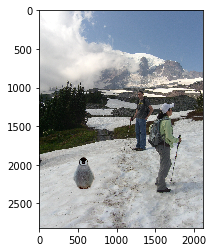

In [13]:
im_blend = poisson_blend(cropped_object, object_mask, background_img)
if im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [ ]:
def mix_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    #TO DO 
    pass

In [ ]:
im_mix = mix_blend(cropped_object, object_mask, background_img)
if im_mix.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(img1, img2):
    pass

## More gradient domain processing (up to 20 pts)